<h1>Predicting the loss rate of a wireless link</h1>
This notebook works on the data collected at the ENS Lyon and the INSA Lyon as part of the wireless networking section in the ANR Concerto project. The goal is to first study the data and see which performance metrics can be useful, and to then build a prediction model for them.

Every line in the data files loaded here represents the average of 100ms of experimental data. 
The measurements were taken at the ENS Lyon (1H, 2nd, 3rd) and the INSA Lyon (Anechoic chamber) by varying the distance between two IEEE 802.11ac APs acting as source and destination. There is a continuous, saturated UDP stream from the source AP to the destination. 

Because of the nature of the cards and system in use, a third AP placed close to the destination AP is acting as monitor and capturing the exchanged frames. This introduces measurement errors due to the fact that what the monitor captures and what the destination captures will not be the exact same stream of frames. To circumvent this issue, we have considered several different ways of computing the channel quality based on both the data frames and the ACK frames captured by the monitor. These computations are detailed later in the notebook. 

The goal is to build a robust model capable of predicting the link quality that 1) provides an accurate prediction of the link quality and that 2) requires few input features. 

Some of the data will be removed as it seems to produce no measurable lossrate (Anechoic chamber with movement) or because there are too few samples to learn any conclusive rules (Anechoic chamber with obstacle).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors

%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 13

In [2]:
# define custom colormaps
norm = matplotlib.colors.Normalize(-1,1)
# summer colors (yellow to dar blue with orange and purple)
color1 = '#ffa600'
color2 = '#ff6361'
color3 = '#bc5090'
color4 = '#003f5c'
colors_summer = [[norm(-1.0), color1],
          [norm(-0.6), color2],
          [norm( 0.6), color3],
          [norm( 1.0), color4]]
cmap_summer = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_summer)

# summer colors divergent
color1d = '#003f5c'
color2d = '#4f697e'
color3d = '#8a96a2'
color4d = '#c6c6c6'
color5d = '#e1a9a3'
color6d = '#f38982'
color7d = '#ff6361'
color8dyellow = '#ffc16a' #an extra shade of yellow
color9dgray = '#2a2b2d'
colors_summer = [[norm(-1.0), color1d],
          [norm(-0.6), color2d],
          [norm(-0.3), color3d],
          [norm( 0.0), color4d],
          [norm( 0.3), color5d],
          [norm( 0.6), color6d],
          [norm( 1.0), color7d]]
cmap_summer_divergent = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_summer)
colorlist_summer_divergent = [color1d, color7d, color3d, color5d, color2d, color6d, color4d, color8dyellow, color9dgray]
# salmon-blue colormap
color1sb = '#54bebe'
color2sb = '#8ad6bb'
color3sb = '#c2eabd'
color4sb = '#f9fdca'
color5sb = '#f9d491'
color6sb = '#ffa46e'
color7sb = '#ff6c6c'
colors_salmon_blue = [[norm(-1.0), color1sb],
          [norm(-0.6), color2sb],
          [norm(-0.3), color3sb],
          [norm( 0.0), color4sb],
          [norm( 0.3), color5sb],
          [norm( 0.6), color6sb],
          [norm( 1.0), color7sb]]
cmap_salmon_blue = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_salmon_blue)
colorlist_salmon_blue = [color1sb, color7sb, color3sb, color5sb, color2sb, color6sb, color4sb]

sns.set_palette(colorlist_summer_divergent)

<h4>Read the data and assign the scenario name</h4>

In [86]:
df1 = pd.read_csv('1H/complete_data.csv', sep='\t')
df1['Scenario'] = 'First floor'
df2 = pd.read_csv('2nd/complete_data.csv', sep='\t')
df2['Scenario'] = 'Second floor'
df3 = pd.read_csv('3rd/complete_data.csv', sep='\t')
df3['Scenario'] = 'Third floor'
df4 = pd.read_csv('CA/complete_data.csv', sep='\t')
df4['Scenario'] = 'Anechoic ch.'
df5 = pd.read_csv('CA_move/complete_data.csv', sep='\t')
df5['Scenario'] = 'Anechoic mvmnt'
df6 = pd.read_csv('CA_doubles/complete_data.csv', sep='\t')
df6['Scenario'] = 'Anechoic ch.'
df7 = pd.read_csv('1H_obstacle/complete_data.csv', sep='\t')
df7['Scenario'] = 'Obstacle 1H'
df8 = pd.read_csv('2nd_obstacle/complete_data.csv', sep='\t')
df8['Scenario'] = 'Obstacle 2nd'
df9 = pd.read_csv('3rd_obstacle/complete_data.csv', sep='\t')
df9['Scenario'] = 'Obstacle 3rd'
df4 =pd.concat([df4, df6])
df10 = pd.read_csv('CA_obstacle/complete_data.csv', sep='\t')
df10['Scenario'] = 'Anechoic obstacle'


In [87]:
df1.head()

,time,mcs,nss,bw,rssi,throughput_monitor,datarate,pktlost_ack,nbpkt_monitor,retry,nbpkt_ack,pktlost_seq_initial,pktlost_seq_new,bad_fcs,distance,antenna,LoS,Scenario
0,8.100307,5.0,3.0,80.0,-62.0628,39374100.0,780.0,19.0,1321.0,76.0,4495.0,8.0,3315.0,0.0,17,left,1,First floor
1,8.200425,5.0,3.0,80.0,-62.1569,37883600.0,780.0,11.0,1268.0,34.0,1275.0,7.0,41.0,0.0,17,left,1,First floor
2,8.300426,5.0,3.0,80.0,-62.1972,40036700.0,780.0,36.0,1339.0,75.0,1301.0,11.0,42.0,0.0,17,left,1,First floor
3,8.400429,5.0,3.0,80.0,-62.2085,39397100.0,780.0,12.0,1314.0,46.0,1325.0,12.0,54.0,0.0,17,left,1,First floor
4,8.500672,5.0,3.0,80.0,-62.4337,38501300.0,780.0,16.0,1289.0,50.0,1276.0,7.0,36.0,0.0,17,left,1,First floor


<h4>The features:</h4>
<li>Time: timestamp of the event in seconds</li>
<li>MCS: Modulation and Coding Scheme (MCS) index (relates to the data rate, higher MCS index means higher data rate)</li>
<li>NSS: Number of Spatial Streams (number of antennas used for the transmission)</li>
<li>BW: The bandwidth in [20, 40, 80, 160] MHz </li>
<li>RSSI: Measures signal strength in dBm</li>
<li>Throughput monitor: The throughput in bits per second (layer 2, i.e., all layer 3 data is considered as useful). It is calculated as the number of frames correctly received by the monitor X the average frame length. Though IPerf generates data packets of equal length, due to aggregation and fragmentation the frame length is not always constant</li>
<li>Datarate: The physical datarate used for the transmission of the layer 2 data (impacted by BW, MCS, NSS, GI (guard interval))</li>
<li>Pktlost_ack: The number of frames counted as lost from the "missing frames" field in the ACKs</li>
<li>Nbpkt_monitor: Total number of frames captured by the monitor and sent by the source</li>
<li>Retry: Number of frames captured by the moniter having a "retry = 1" flaf</li>
<li>Nbpkt_ack: Total number of frames acknowledged in the ACKs captured by the monitor</li>
<li>Pktlost_seq_initial: The number of lost frames based on sequential numbers. This computation mainly counts the number of events that can be seen as a loss (a hole in the list of sequential numbers will always be counted as a single error, no matter how many consecutive frames were lost. For example, [1,2,5] and [1,2,3,5] will both generate one error)</li>
<li>Pktlost_seq_new: The number of lost frames based on sequential numbers. This computation should count exactly how many frames were lost, however it is less precise than planned and we do not use it for the time being</li>
<li>Bad_fcs: Number of frames seen by the monitor with the Bad FCS flag set to 1 </li>
<li>Distance: The distance in meters between the source and the destination</li>
<li>Antenna: The orientation of the antenna for all three APs (source, destination, monitor). The orientation can be left, fan, vertical, horizontal</li>
<li>LoS: Line of Sight. Always 1 except for the scenarios including obstacles</li>
<li>Scenario: The physical location of the experiment and whether an obstacle was present or not</li>

In [88]:
# the df5, df6, and df10 are excluded for the moment for the reasons explained earlier, but they can be added to this list
frames = [df1, df2, df3, df7, df8, df9, df4]
for df in frames:
    df['retry_ack'] = df['retry']/df['nbpkt_ack']
    df['retry_monitor'] = df['retry']/df['nbpkt_monitor']
    df['missing_frames_ack'] = df['pktlost_ack']/df['nbpkt_ack']
    df['missing_frames_monitor'] = df['pktlost_ack']/df['nbpkt_monitor']
    df['lossrate_ack'] = df['pktlost_seq_initial']/df['nbpkt_ack']
    df['lossrate_monitor'] = df['pktlost_seq_initial']/df['nbpkt_monitor']
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['datarate'], inplace=True)
    df.index = range(len(df.index))

data_all = pd.concat(frames)
data_all.index = range(len(data_all.index))
data_copy = data_all.copy()

<ipython-input-89-9bf13969fb3b>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_all.drop('time', axis=1).hist(ax = ax)


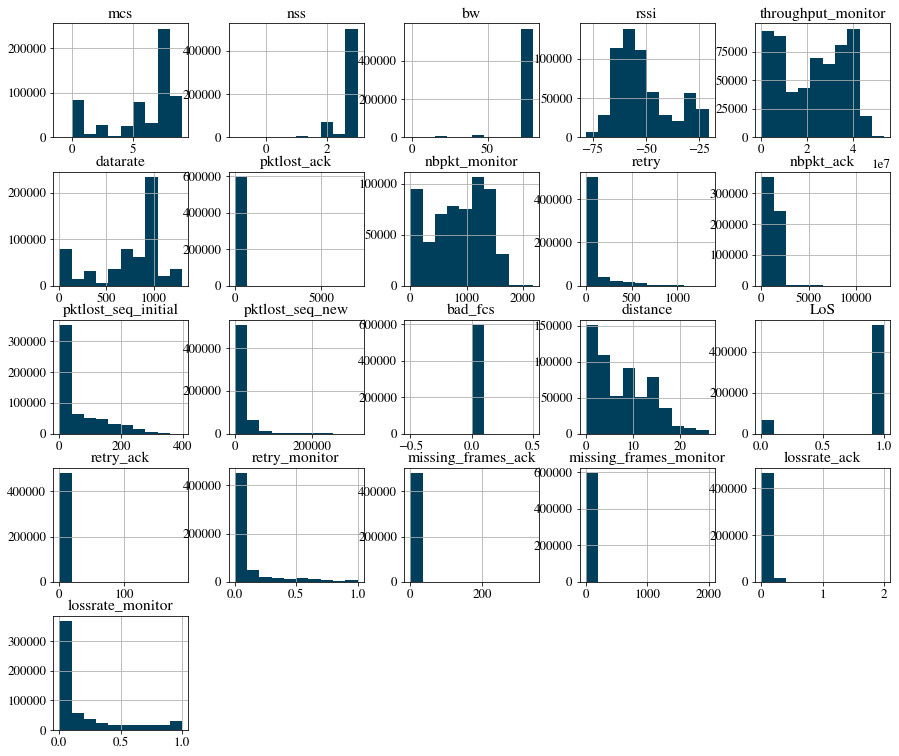

In [89]:
fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_all.drop('time', axis=1).hist(ax = ax)
plt.show()

In [18]:
sorted_by_nbpkt_ack = data_all.sort_values(by=['nbpkt_ack'])[['time', 'nbpkt_ack', 'pktlost_ack', 'Scenario', 'distance', 'antenna']]
sorted_by_nbpkt_ack.tail(n=10)

,time,nbpkt_ack,pktlost_ack,Scenario,distance,antenna
235887,8.402897,9255.0,2.0,Second floor,14.0,vertical
171872,18.766151,9345.0,1.0,Second floor,10.0,fan
131961,14.427361,9418.0,78.0,Second floor,14.0,vertical
48679,10.520734,9430.0,40.0,First floor,9.0,left
236265,46.553681,9489.0,76.0,Second floor,14.0,vertical
200708,58.693360,9527.0,111.0,Second floor,14.0,vertical
236106,30.395269,9588.0,6.0,Second floor,14.0,vertical
390576,12.227477,9680.0,7.0,Obstacle 1H,5.0,vertical
211137,38.087720,12769.0,3463.0,Second floor,9.0,left
340162,101.150461,12928.0,3265.0,Second floor,3.0,left


In [13]:
data_all['bad_fcs'].value_counts()

0.0    594982
Name: bad_fcs, dtype: int64

In [24]:
sorted_by_nbpkt_ack = data_all.sort_values(by=['missing_frames_ack'])[['time', 'nbpkt_ack', 'pktlost_ack', 'missing_frames_ack', 'Scenario', 'distance', 'antenna']]
sorted_by_nbpkt_ack.tail(n=10)

,time,nbpkt_ack,pktlost_ack,missing_frames_ack,Scenario,distance,antenna
594972,126.002079,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal
594973,126.102459,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal
594974,126.202609,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal
594975,126.302852,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal
594976,126.403281,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal
594977,126.504202,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal
594978,126.604773,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal
594979,126.704791,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal
594980,126.833387,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal
594981,127.020503,0.0,0.0,NaN,Anechoic ch.,0.0,horizontal


<ipython-input-12-9bac6cb7ae45>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_cleaned.hist(ax=ax)


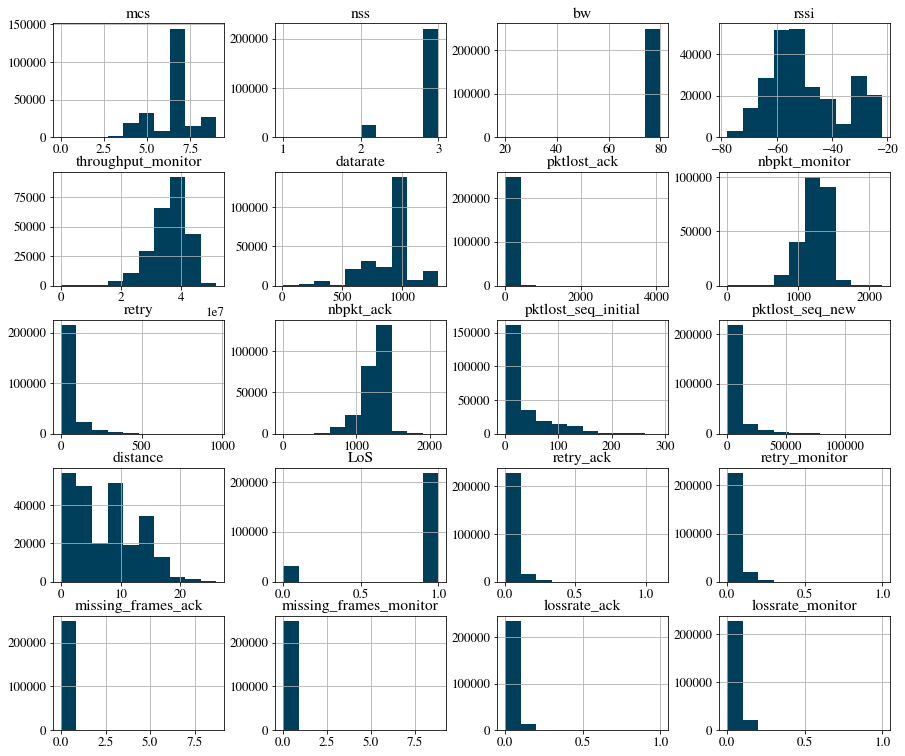

In [12]:
fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_cleaned = data_all[(data_all['nbpkt_monitor']-data_all['nbpkt_ack']).abs() < (data_all['nbpkt_monitor']*0.25)]
data_cleaned.hist(ax=ax)
plt.show()

In [17]:
data_cleaned.sort_values(by=['missing_frames_ack']).tail(n=30)

,time,mcs,nss,bw,rssi,throughput_monitor,datarate,pktlost_ack,nbpkt_monitor,retry,...,distance,antenna,LoS,Scenario,retry_ack,retry_monitor,missing_frames_ack,missing_frames_monitor,lossrate_ack,lossrate_monitor
166463,39.598272,6.996718,2.007659,79.824945,-59.935449,2.707389e+07,649.978118,811.0,914.0,59.0,...,5.0,left,1,Second floor,0.070574,0.064551,0.970096,0.887309,0.014354,0.013129
415411,38.044185,8.985694,2.007153,80.000000,-29.829757,2.034973e+07,866.779685,658.0,699.0,56.0,...,2.0,vertical,0,Obstacle 3rd,0.084084,0.080114,0.987988,0.941345,0.003003,0.002861
433267,51.978086,8.525880,2.322981,67.412008,-26.610766,1.428652e+07,751.258799,496.0,483.0,19.0,...,4.0,vertical,0,Obstacle 3rd,0.038384,0.039337,1.002020,1.026915,0.014141,0.014493
207272,12.436255,8.950754,2.042211,78.753769,-56.229146,2.921446e+07,857.289447,1063.0,995.0,24.0,...,5.0,fan,1,Second floor,0.024024,0.024121,1.064064,1.068342,0.039039,0.039196
39428,84.122387,5.023290,2.994178,80.000000,-59.689956,2.060877e+07,780.500728,602.0,687.0,167.0,...,8.0,fan,1,First floor,0.313321,0.243086,1.129456,0.876274,0.001876,0.001456
139890,107.420396,5.836601,2.171242,76.679739,-63.240523,1.455986e+07,564.853595,1062.0,765.0,632.0,...,26.0,vertical,1,Second floor,0.674493,0.826144,1.133404,1.388235,0.037353,0.045752
130759,31.711075,4.049724,2.832413,32.007366,-52.499079,1.333912e+07,190.182320,484.0,543.0,81.0,...,14.0,vertical,1,Second floor,0.193317,0.149171,1.155131,0.891344,0.002387,0.001842
3275,99.502469,4.339768,2.841699,73.667954,-68.652510,7.739592e+06,525.501931,295.0,259.0,121.0,...,15.0,horizontal,1,First floor,0.599010,0.467181,1.460396,1.138996,0.000000,0.000000
375226,81.265160,7.238267,2.211191,47.870036,-27.030686,1.667371e+07,415.550542,946.0,554.0,10.0,...,1.0,vertical,1,Third floor,0.015798,0.018051,1.494471,1.707581,0.086888,0.099278
144454,78.684832,5.015894,2.018543,79.682119,-61.264901,2.221086e+07,520.821192,1191.0,755.0,38.0,...,10.0,horizontal,1,Second floor,0.053977,0.050331,1.691761,1.577483,0.011364,0.010596


<ipython-input-19-27d4f129ad85>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_cleaned.hist(ax=ax)


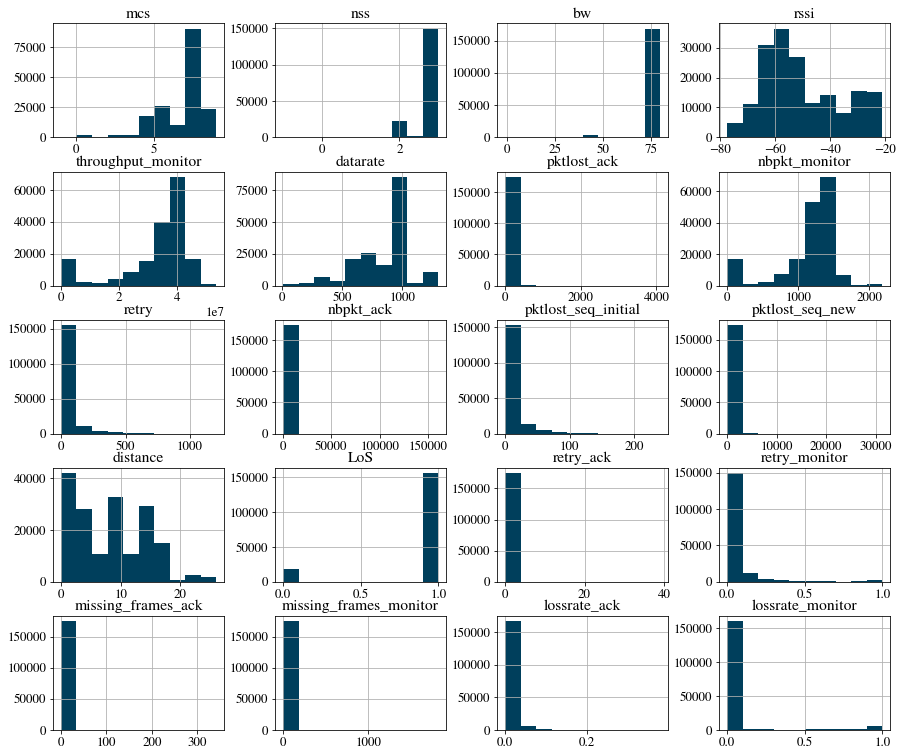

In [19]:
fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_cleaned = data_all[data_all['pktlost_seq_new'] < (data_all['nbpkt_ack'])]
data_cleaned.hist(ax=ax)
plt.show()

I removed the infinities (replaced them with NaNs) that occur because the number of frames as counted by the ACKs is always zero. This happens often in the anechoic chamber where the closeness of the monitor and the destination (that transmits the ACKs) makes it impossible for the monitor to properly receive the ACKs. 

**Choosing relevant performance metrics**

There are still many values >100\% in all loss rate and retry rate computations:
<li>Retry ack: ratio between the number of retries and the number of acknowledged frames in the ACKs</li>
<li>Missing frames ack: ratio between the numer of lost frames as reported by the ACKs and the number of acknowledged frames in the ACKs</li>
<li>Missing frames monitor: ratio between the number of lost frames as reported by the ACKs and the number of frames counted as well received by the monitor</li>
<li>Lossrate ack: ratio between the number of lost frames as counted by the monitor (hopes in the list of sequence numbers) and the number of frames acknowledged by the ACKs</li>

The only values that are reasonably bounded are the retry_monitor, i.e., the number of retries seen by the monitor divided by the number of frames seen by the monitor and the lossrate monitor, i.e., the number of missing sequence numbers (initial computation baes on gaps) divided by the number of frames seen by the monitor. For the rest of the notebook we'll focus on these two metrics.

<h2> Correlations </h2>

We look at [Pearson\'s](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), [Spearman's](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), and [Kendall's](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) correlation coefficients for linear and quadratic features. The goal is to find the features, or combinations of features, that correlate the most with the link quality metric we wish to predict.



In [137]:
print(data_all.corr()['lossrate_monitor'])

mcs                       0.348318
nss                       0.030569
bw                        0.047338
rssi                     -0.150439
throughput_monitor       -0.592533
datarate                  0.319483
pktlost_ack               0.062060
nbpkt_monitor            -0.698360
retry                    -0.313959
nbpkt_ack                 0.260538
pktlost_seq_initial       0.415230
pktlost_seq_new           0.475993
distance                  0.151901
LoS                      -0.075502
retry_ack                -0.053060
retry_monitor            -0.222451
missing_frames_ack       -0.004584
missing_frames_monitor    0.121536
lossrate_ack              0.322076
lossrate_monitor          1.000000
Name: lossrate_monitor, dtype: float64


In [138]:
print(data_all.corr()['retry_monitor'])

mcs                      -0.584982
nss                      -0.380729
bw                       -0.604874
rssi                      0.008294
throughput_monitor       -0.387778
datarate                 -0.637278
pktlost_ack              -0.002648
nbpkt_monitor            -0.241866
retry                     0.597722
nbpkt_ack                -0.269875
pktlost_seq_initial      -0.311486
pktlost_seq_new          -0.202594
distance                 -0.067310
LoS                       0.032556
retry_ack                 0.091412
retry_monitor             1.000000
missing_frames_ack        0.039911
missing_frames_monitor    0.066229
lossrate_ack             -0.140067
lossrate_monitor         -0.222451
Name: retry_monitor, dtype: float64


In [25]:
from sklearn.preprocessing import PolynomialFeatures
def features_correlation_simple(X, Y_loss, Y_retry, scenario, degree=2, method = 'spearman'):
    # create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(X)
    # calculate correlation coefficients 
    poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(input_features=X.columns))
    poly_features['lossrate'] = Y_loss
    poly_features['retryrate'] = Y_retry
    poly_features['Scenario'] = scenario
    lossrate_corr = poly_features.corr(method=method)['lossrate']#.sort_values(key=abs)
    retryrate_corr = poly_features.corr()['retryrate']#.sort_values(key=abs)

    sorted_index = lossrate_corr.abs().argsort()
    fig, ax = plt.subplots(figsize = (20,7))    
    x_axis = np.arange(len(lossrate_corr))
    ax.bar(x_axis-0.2, height=lossrate_corr[sorted_index].abs(), width=0.4, label='Lossrate monitor')
    ax.bar(x_axis+0.2, height=retryrate_corr[sorted_index].abs(), width=0.4, label='Retry rate monitor')

    # x = lossrate_corr.keys() 
    # y = lossrate_corr.values 
    # positive = ['Positive' if i > 0 else 'Negative' for i in y]
    # sns.barplot(x=x, y=abs(y), hue=positive, dodge=False, palette=[color1d, color7d])

    plt.legend(loc='upper left')
    plt.xticks(x_axis, lossrate_corr.keys()[sorted_index], rotation=90)
    threshold = 0.5
    plt.axhline(threshold, ls='dotted', color=color9dgray, lw=4)
    return lossrate_corr

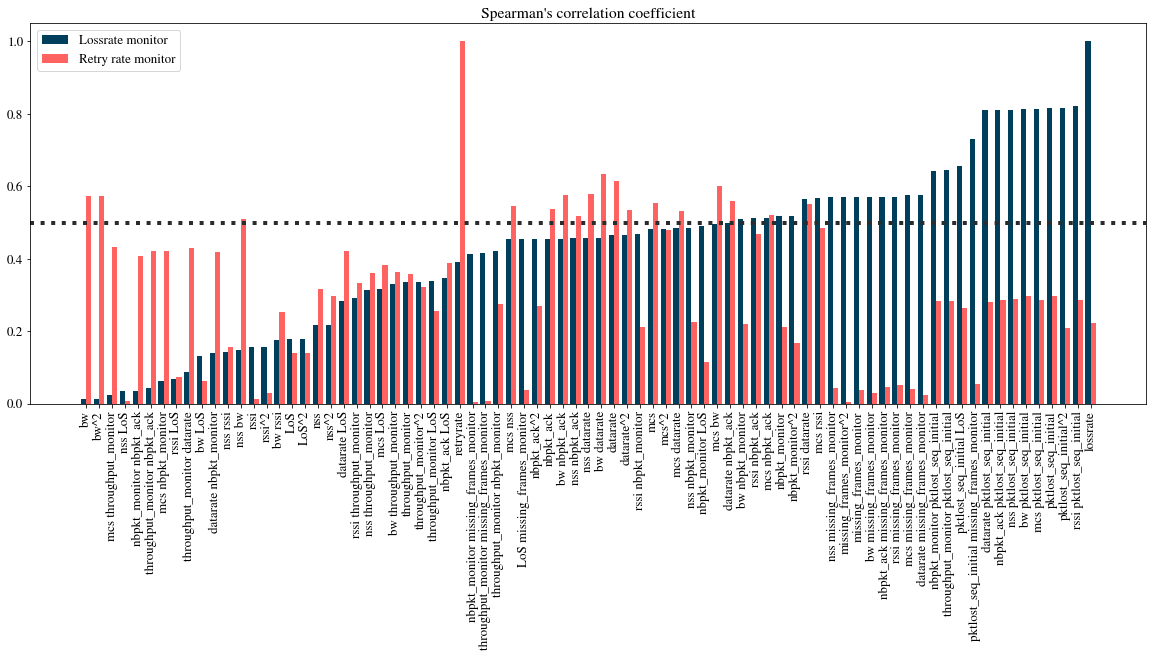

In [27]:
X = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'bad_fcs'], axis=1, errors='ignore')
y_loss = data_all['lossrate_monitor'].copy()
y_retry = data_all['retry_monitor']
features_correlation_simple(X, y_loss, y_retry, scenario=data_all['Scenario'], degree=2, method='spearman')
plt.title('Spearman\'s correlation coefficient')
plt.savefig('figures/spearman_corr.png', dpi=300, bbox_inches='tight')

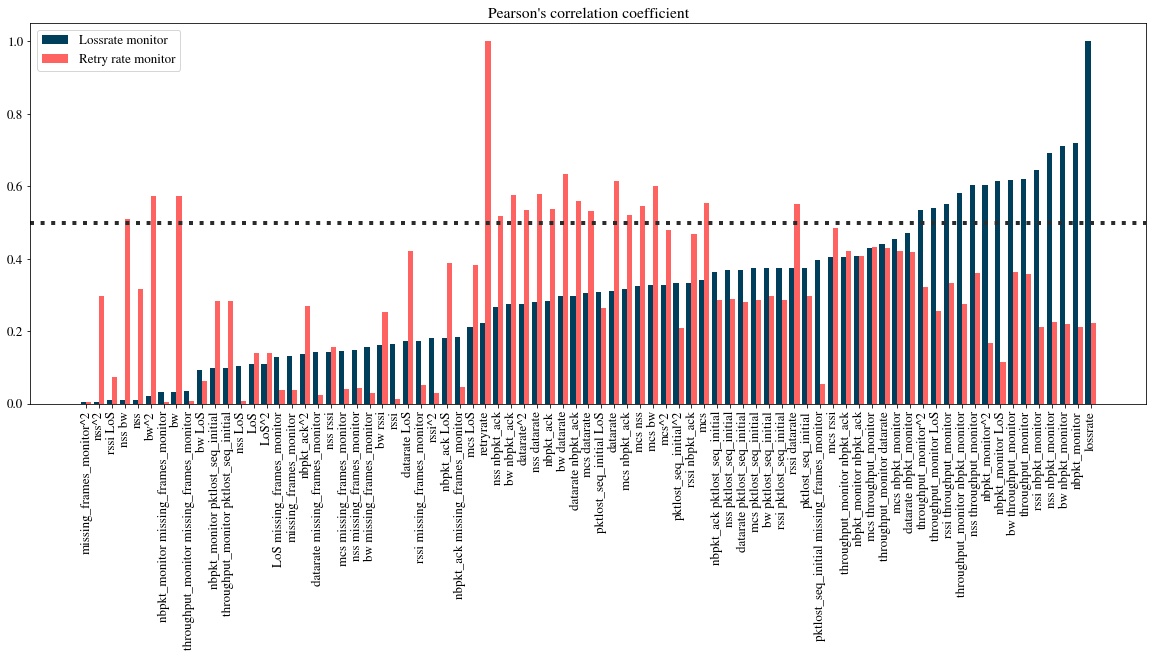

In [28]:
X = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'bad_fcs'], axis=1, errors='ignore')
y_loss = data_all['lossrate_monitor'].copy()
y_retry = data_all['retry_monitor']
features_correlation_simple(X, y_loss, y_retry, scenario=data_all['Scenario'], degree=2, method='pearson')
plt.title('Pearson\'s correlation coefficient')
plt.savefig('figures/pearson_corr.png', dpi=300, bbox_inches='tight')

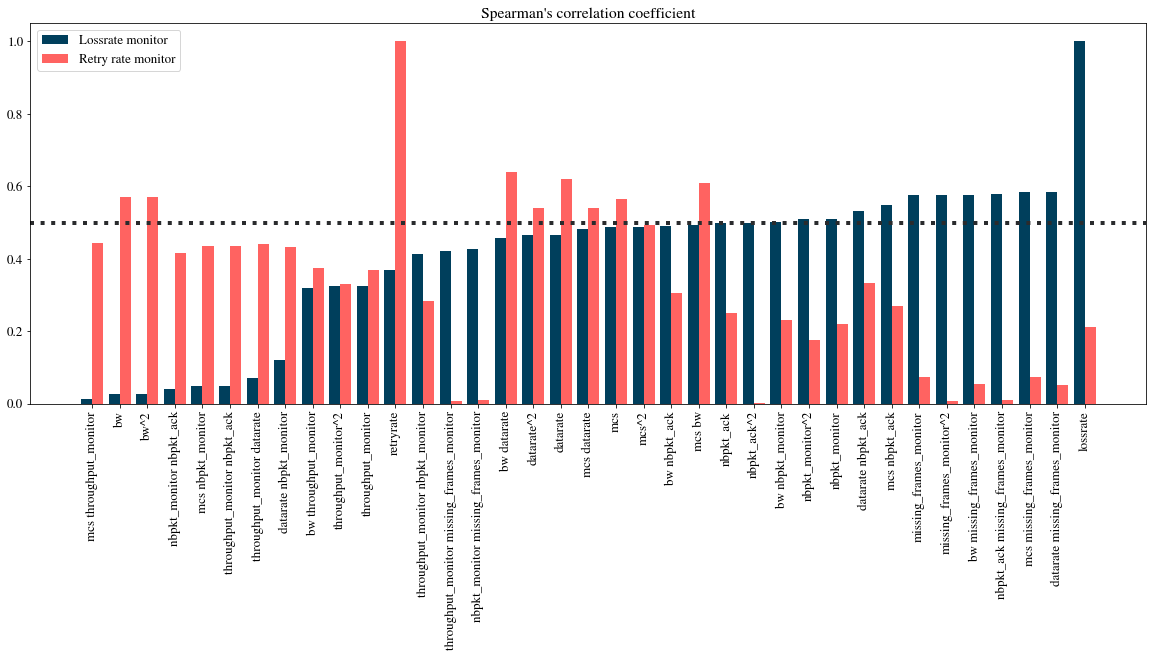

In [11]:
X = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'rssi', 'LoS', 'nss', 'pktlost_seq_initial'], axis=1, errors='ignore')
y_loss = data_all['lossrate_monitor'].copy()
y_retry = data_all['retry_monitor']
features_correlation_simple(X, y_loss, y_retry, scenario=data_all['Scenario'], degree=2, method='spearman')
plt.title('Spearman\'s correlation coefficient')
plt.savefig('figures/spearman_corr_reduced.png', dpi=300, bbox_inches='tight')

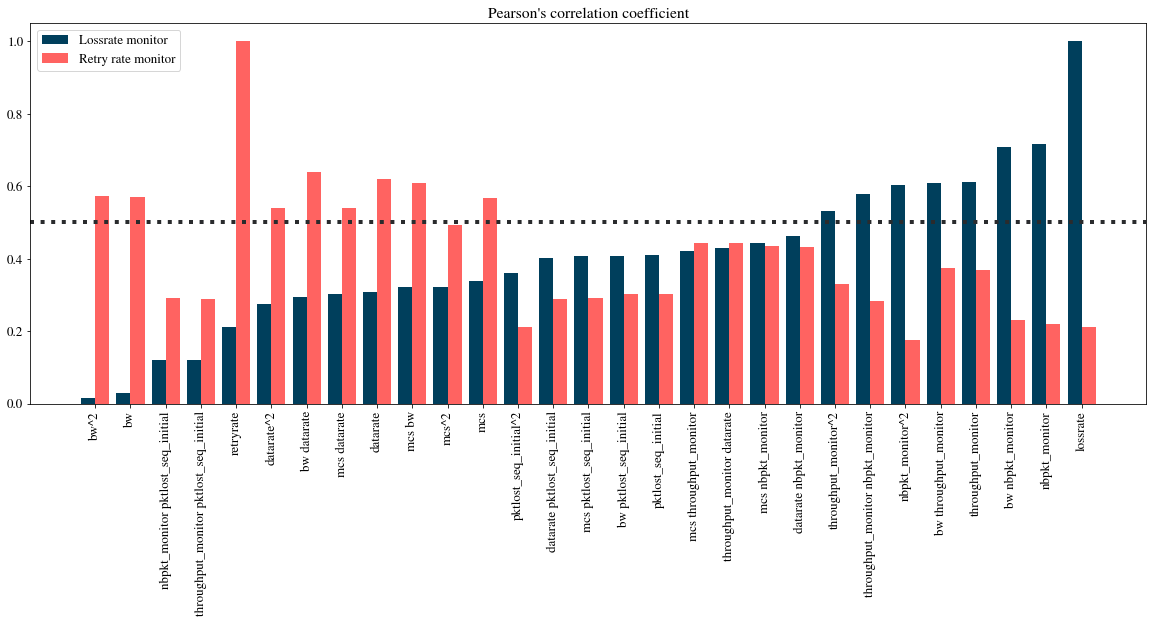

In [12]:
X = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'nss', 'LoS', 'missing_frames_monitor', 'rssi', 'nbpkt_ack'], axis=1, errors='ignore')
y_loss = data_all['lossrate_monitor'].copy()
y_retry = data_all['retry_monitor']
features_correlation_simple(X, y_loss, y_retry, scenario=data_all['Scenario'], degree=2, method='pearson')
plt.title('Pearson\'s correlation coefficient')
plt.savefig('figures/pearson_corr_reduced.png', dpi=300, bbox_inches='tight')

In [29]:
def correlations_per_scenario(data, data_all, degree=2, metric = 'retry_monitor', type='pearson'):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(data)
    poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(input_features=data.columns))
    poly_features[metric] = data_all[metric]
    poly_features['Scenario'] = data_all['Scenario']
    correlation_complete = pd.DataFrame()
    for i in data_all['Scenario'].unique():
        a = pd.DataFrame(data=poly_features.loc[data_all['Scenario'] == i].corr(method=type)[metric])
        # a['Scenario'] = i
        # print(poly_features.loc[data_all['Scenario'] == i].corr()['retry_monitor'])
        correlation_complete = pd.concat([correlation_complete, a], axis=1)
    correlation_complete = correlation_complete.sort_index(axis=1)
    correlation_complete.columns = data_all['Scenario'].unique()
    return correlation_complete

<h4>Correlation heatmaps</h4>
The heatmaps only show selected features (chosen with trial and error) so as to have legible figures. 

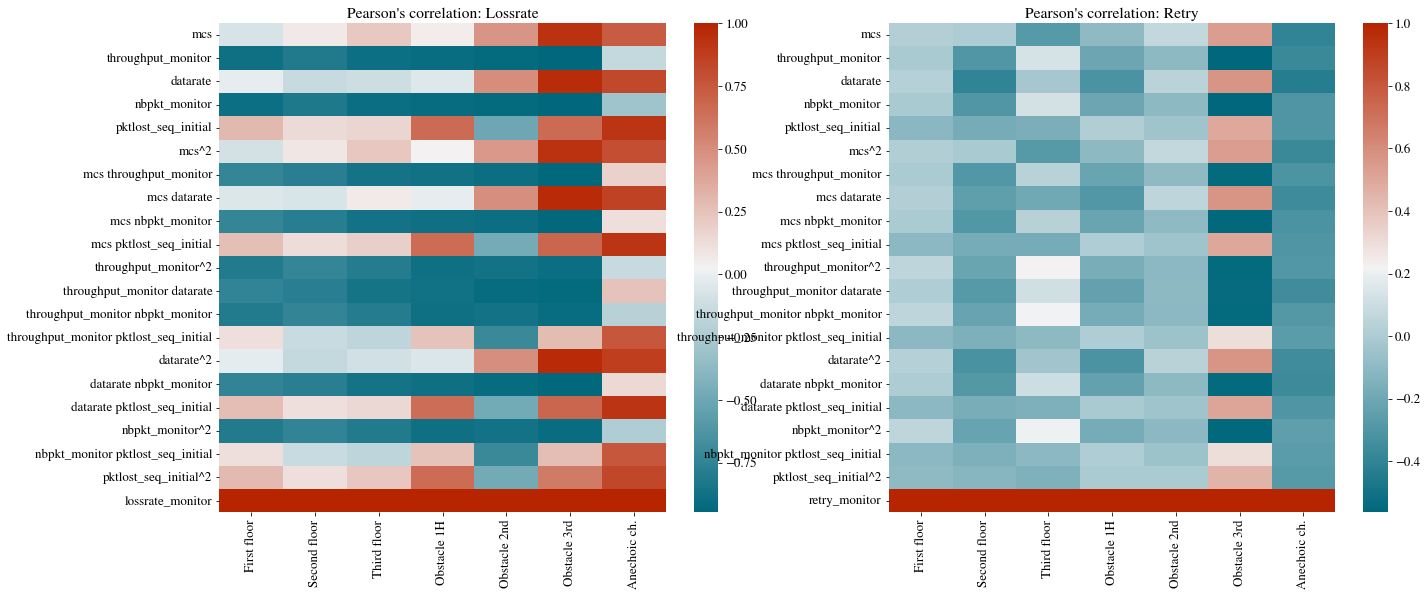

In [31]:
data_new = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'nss', 'LoS', 'missing_frames_monitor', 'rssi', 'bw', 'nbpkt_ack', 'bad_fcs'], axis=1, errors='ignore')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='lossrate_monitor')
plt.figure(figsize=(22,9))
plt.subplot(1,2,1)
plt.title('Pearson\'s correlation: Lossrate')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.subplot(1,2,2)
plt.title('Pearson\'s correlation: Retry')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='retry_monitor')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()

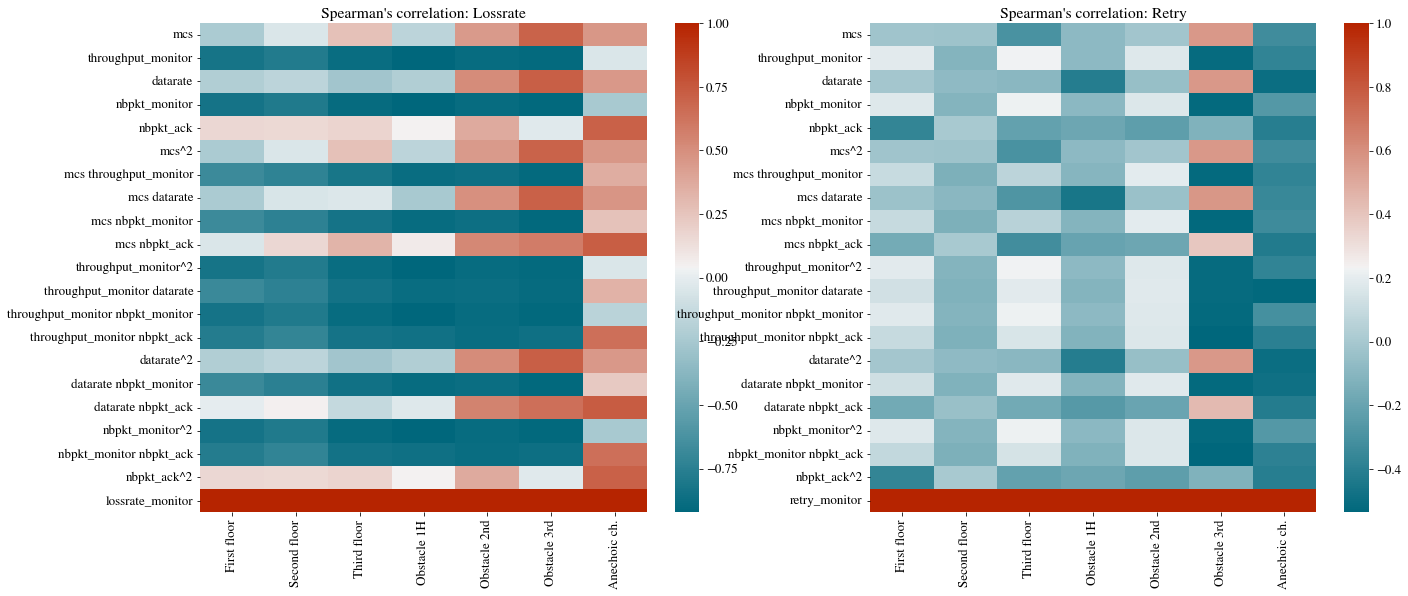

In [15]:
data_new = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'bw', 'LoS', 'nss', 'pktlost_seq_initial', 'rssi', 'missing_frames_monitor'], axis=1, errors='ignore')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='lossrate_monitor', type='spearman')
plt.figure(figsize=(22,9))
plt.subplot(1,2,1)
plt.title('Spearman\'s correlation: Lossrate')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.subplot(1,2,2)
plt.title('Spearman\'s correlation: Retry')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='retry_monitor', type='spearman')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()

/home/marija/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/home/marija/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


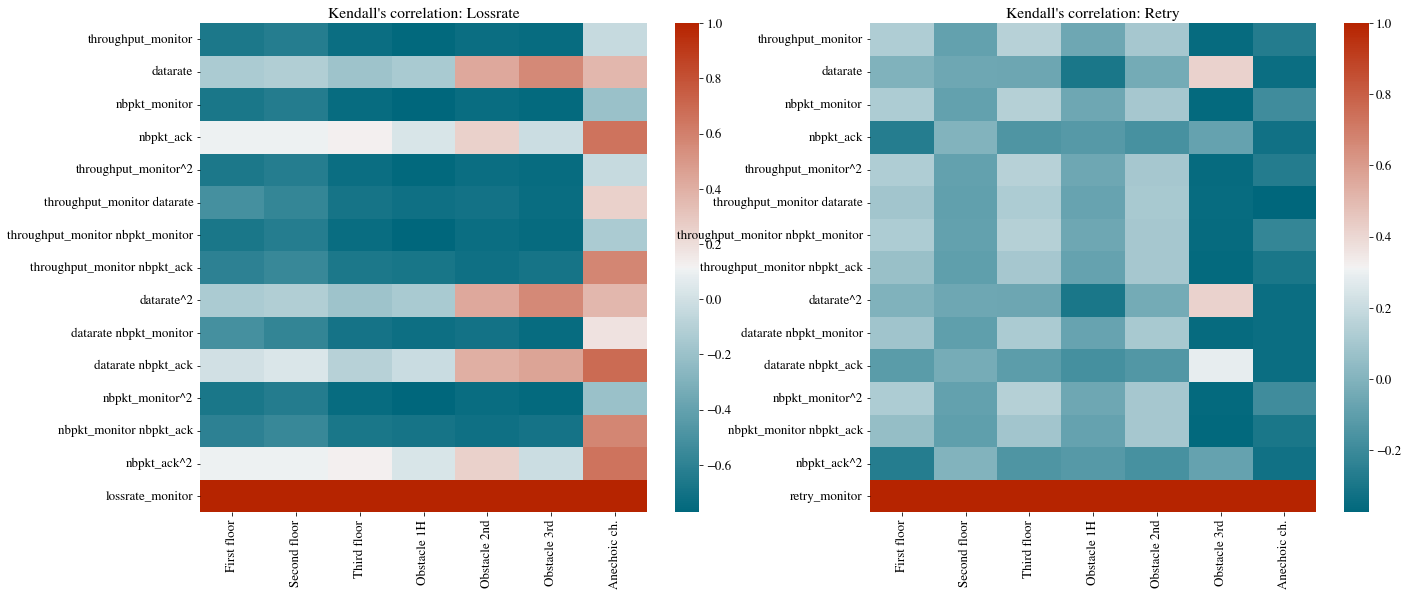

In [16]:
data_new = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'pktlost_seq_initial', 'missing_frames_monitor', 'mcs', 'rssi', 'bw', 'LoS', 'nss'], axis=1, errors='ignore')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='lossrate_monitor', type='kendall')
plt.figure(figsize=(22,9))
plt.subplot(1,2,1)
plt.title('Kendall\'s correlation: Lossrate')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.subplot(1,2,2)
plt.title('Kendall\'s correlation: Retry')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='retry_monitor', type='kendall')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()

<h4>Correlation conclusions</h4>

**Retry rate** (retries/nb frames captured by monitor)
<li>It will likely be difficult to build a precise prediction model. All correlation coefficients show very weak links between the retry rate (number of retries / number of frames counted by monitor) and any other feature. It is less true for specific scenarios, i.e., the anechoic chamber and the 3rd floor with obstacle. </li>


**Lossrate** (sequence number errors/nb frames captured by monitor)
<li>The correlationas are much stronger, however they are very different for the anechoic chamber and the corridor (as we expected). Since we're building linear models for the moment, we focus a bit more on Spearman's correlation coefficients. </li>
<li>The lossrate in the corridor scenarios (everything 1H, 2nd, and 3rd) is most strongly correlated to the nbpkt_monitor and the throughput_monitor. These two features are almost the same, as the frame length is usually fairly stable so the calculated throughput is a linear function of the number of frames. I believe that this correlation will be less strong once we have the data for an unsaturated scenario, because right now the number of frames received directly measures the quality of the communication. </li> 
<li>In the anechoic chamber, the lossrate seems to most strongly correlate with the datarate and the mcs. I am not exactly sure why, but these two features are also very linked to each other. The datarate is mostly dependent on the GI, NSS, BW, and MCS. The first three features are mainly constant in all scenarios, so the datarate and the MCS are almost a linear function of each other. This might capture the behavior the the rate adaptation algorthm, but also the data from the anechoic chamber is fairly limited when it comes to the distribution of the lossrate values. Most of the values are extremely close to 0, and the only distances for which we have lossrates > 0.2 are 1 and 2 meters. This indicated that it is more the signal propagation (not enough path diversity for MIMO) than the actualy signal strength/quality that generated these losses. As a result, for the moment it is difficult to make conclusive thoughts on the behavior measured in the anechoic chamber. </li>
<li>I try to look at Kendall's correlation as well, because some mention it as an improvement of Spearman's, but I am still not sure about the interpretation. "Intuitively, the Kendall correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) rank (i.e. relative position label of the observations within the variable: 1st, 2nd, 3rd, etc.) between the two variables, and low when observations have a dissimilar (or fully different for a correlation of −1) rank between the two variables." This makes sense for us, as it means that if the sorted observations have a similar order for two different features, then those two features are correlated.</li>
<li>As before, I'll try to make a general model that covers all the data, and a specific model for the corridor and the anechoic data</li>

<h4>To do</h4>
Do a distribution test to see what's going on with the data on the 3rd floor with obstacle.

<h2>Building the model</h2>

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

linear_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()), 
            ("regressor", LinearRegression()),]
)
poly_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler()), 
            ("regressor", LinearRegression()),]
)

def plot_model(X_train, y_train, X_test, y_test, model_class, alphas, antenna_names=[], plot = 1, **model_kargs):
    for alpha in alphas:
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        # linear model
        linear_pipe = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()), 
                    ("regressor", model),]
        )
        linear_model = linear_pipe.fit(X_train, y_train)
        y_predict_linear = linear_model.predict(X_test)
        linear_score = linear_model.score(X_test, y_test)
        # calculate sorted coefficients
        feature_names = linear_model.named_steps['scaler'].get_feature_names_out(input_features=X_train.columns.append(antenna_names))
        feature_coefs = linear_model.named_steps['regressor'].coef_
        sorted_indexes = abs(feature_coefs).argsort()
        sorted_coef_linear = np.c_[feature_names[sorted_indexes], feature_coefs[sorted_indexes]]
        
        # polynomial model
        poly_pipe = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                   ("poly", PolynomialFeatures(degree=2, include_bias=False)),
                    ("scaler", StandardScaler()), 
                    ("regressor", model),]
        )
        poly_model = poly_pipe.fit(X_train, y_train)
        y_predict_poly = poly_model.predict(X_test)
        poly_score = poly_model.score(X_test,y_test)
        # calculate sorted coefficients
        feature_names = poly_model.named_steps['poly'].get_feature_names_out(input_features=X_train.columns.append(antenna_names))
        feature_coefs = poly_model.named_steps['regressor'].coef_
        sorted_indexes = abs(feature_coefs).argsort()
        sorted_coef_poly = np.c_[feature_names[sorted_indexes], feature_coefs[sorted_indexes]]
        
        if plot:
            plt.rcParams["figure.figsize"] = (5,7)
            plt.figure(1)
            plt.grid()
            sns.scatterplot(x=y_test, y=y_predict_linear, alpha=0.3, s=40, linewidth=0.1, hue=hue_markers, palette=colorlist_summer_divergent[0:len(hue_markers.unique())])
            plt.plot(y_test, y_test, label='Ideal', c='k')
            plt.xlabel('Groud truth', fontsize=20)
            plt.ylabel('Prediction', fontsize=20)        
            plt.legend(loc='lower right', fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.ylim([-0.2, 1.2])

            plt.figure(2)
            plt.grid()
            sns.scatterplot(x=y_test, y=y_predict_poly, alpha=0.3, s=40, linewidth=0.1, hue=hue_markers, palette = colorlist_summer_divergent[0:len(hue_markers.unique())])
            plt.plot(y_test, y_test, label='Ideal', c='k')
            plt.xlabel('Groud truth', fontsize=20)
            plt.ylabel('Prediction', fontsize=20)
            plt.legend(loc='lower right', fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)        
            plt.ylim([-0.2, 1.2])
        
            print("Linear and poly R2 scores: ", linear_score, poly_score)
            print("Linear and poly mean absolute error: ", mean_absolute_error(y_test, y_predict_linear), mean_absolute_error(y_test, y_predict_poly))
            print("Linear and poly RMSE: ", mean_squared_error(y_test, y_predict_linear, squared=False), mean_squared_error(y_test, y_predict_poly, squared=False))
        return linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test, y_predict_poly

**<h4>Retry rate </h4>**

Linear and poly R2 scores:  0.6061341317669452 0.823425517920168
Linear and poly mean absolute error:  0.07601069214602581 0.04092555564479179
Linear and poly RMSE:  0.12176120842747518 0.08152649032638151


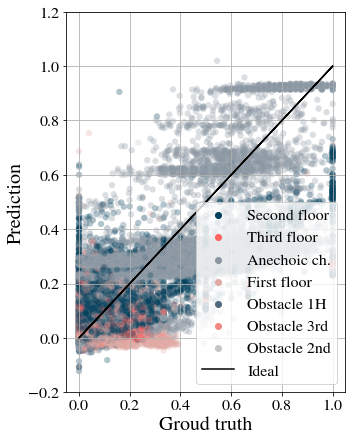

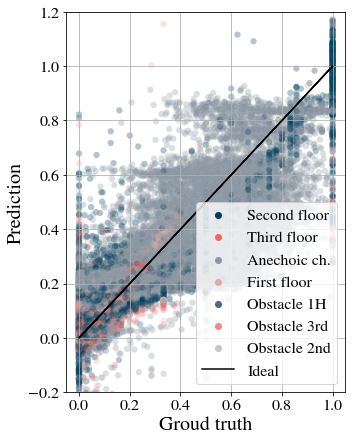

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data_all.drop(['antenna', 'Scenario', 'retry', 'retry_monitor'], axis=1)#[['mcs', 'bw', 'datarate', 'rx', 'nss', 'throughput']]
# X = data_all[['mcs', 'datarate', 'bw']]
y = data_all['retry_monitor'].copy()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
bins = np.linspace(0, len(data_all) , 20)
y_binned = np.digitize(y, bins)
for train_index, test_index in split.split(data_all, y_binned):
    hue_markers = data_all['Scenario'].loc[test_index]
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]
linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])


So we actually get a decent prediction, but we are useing all the features here and we know that most of them are irrelevant to the retry rate. However if we do try to remove features then we would get a worse prediction (try for example the model that used X=[badwidth, mcs, datarate], i.e., the most relevant features for the retry rate, and see that we get an R2 of around 0.6). We could make indivudual models per scenario, but I am afraid we will just be overfitting to the data very fast.

**<h4>Lossrate</h4>**
The lossrate here is the ratio between the number of frames counted as missing (using the initial computation based on the missing sequence numbers where we only record the event that a loss occured, but we do not know if it is a single frame or several) and the number of frames captured by the monitor.

Linear and poly R2 scores:  0.7187642552028692 0.8472868555084176
Linear and poly mean absolute error:  0.11598992637101661 0.06429228826471901
Linear and poly RMSE:  0.15288419185053856 0.11265890678466123


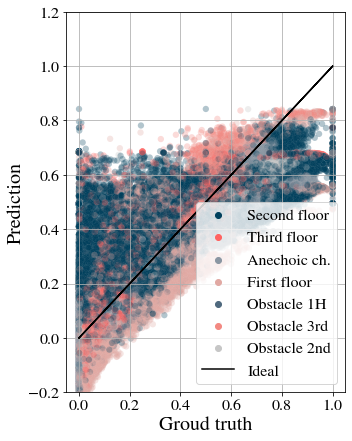

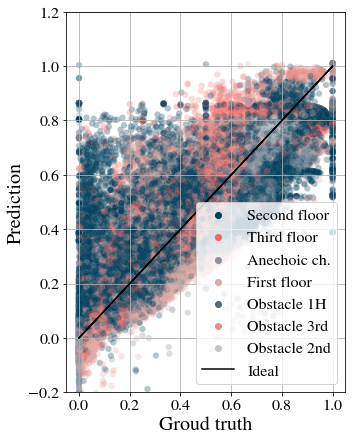

In [124]:
from sklearn.model_selection import StratifiedShuffleSplit
data = data_all.copy()
# X = data.drop(['antenna', 'Scenario', 'retry', 'lossrate_monitor', 'pktlost_seq_initial', 'pktlost_seq_new'], axis=1)#[['mcs', 'bw', 'datarate', 'rx', 'nss', 'throughput']]
features = ['mcs', 'datarate', 'throughput_monitor', 'nbpkt_monitor']
X = data[features]
y = data['lossrate_monitor'].copy()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
bins = np.linspace(0, len(data) , 20)
y_binned = np.digitize(y, bins)
for train_index, test_index in split.split(data, y_binned):
    hue_markers = data['Scenario'].loc[test_index]
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]
linear_model_all, poly_model_all, sorted_coef_linear_all, sorted_coef_poly_all, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])

So we got a better R2 score, and the errors are comparable, however in this case we are already using a very simple set of features as we removed the ones that do not really correlate with the lossrate in any scenario.

In [148]:
from scipy import stats
stats.ks_2samp(data_all['nbpkt_ack'], data_all['nbpkt_monitor'])

KstestResult(statistic=0.2954147457795761, pvalue=0.0)

<h4>Lossrate model per scenario</h4>

In [112]:
linear_model = {}
poly_model = {}
sorted_coef_linear = {}
sorted_coef_poly = {}
r2_score = {} 
rmse = {}
mae = {}

for i in frames:
    data = i.copy()
    X = data[features]
    y = data['lossrate_monitor'].copy()

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    bins = np.linspace(0, len(data) , 20)
    y_binned = np.digitize(y, bins)
    for train_index, test_index in split.split(data, y_binned):
        # hue_markers = data['Scenario'].loc[test_index]
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
    linear_model[i['Scenario'][0]], poly_model[i['Scenario'][0]], sorted_coef_linear[i['Scenario'][0]], sorted_coef_poly[i['Scenario'][0]], y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1], plot = 0)
    plt.show()

In [115]:
linear_model['All Data'] = linear_model_all
poly_model['All Data'] = poly_model_all
sorted_coef_linear['All Data'] = sorted_coef_linear_all
sorted_coef_poly['All Data'] = sorted_coef_poly_all

In [126]:
def calculate_errors_across_datasets (poly_model, frames=frames, features=features):
    poly_score = pd.DataFrame()
    mae = pd.DataFrame()
    rmse = pd.DataFrame()
    for i in range(len(frames)):
        for j in range(len(frames)):
            data = frames[j].copy()
            X = data[features]
            y = data['lossrate_monitor'].copy()

            split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            bins = np.linspace(0, len(data) , 20)
            y_binned = np.digitize(y, bins)
            for train_index, test_index in split.split(data, y_binned):
                X_test = X.loc[test_index]
                y_test = y.loc[test_index]
            y_predict_poly = poly_model[frames[i]['Scenario'][0]].predict(X_test)
            poly_score.loc[i,j] = poly_model[frames[i]['Scenario'][0]].score(X_test,y_test)
            mae.loc[i,j] = mean_absolute_error(y_test, y_predict_poly)
            rmse.loc[i,j] = mean_squared_error(y_test, y_predict_poly, squared=False)
        poly_score.rename({i: frames[i]['Scenario'][0]}, axis=0, inplace=True)
        mae.rename({i: frames[i]['Scenario'][0]}, axis=0, inplace=True)    
        rmse.rename({i: frames[i]['Scenario'][0]}, axis=0, inplace=True)
    rmse.columns = rmse.index
    mae.columns = mae.index
    poly_score.columns = poly_score.index
    return poly_score, rmse, mae

frames_with_data_all = frames.copy()
data_copy['Scenario'] = 'All Data'
frames_with_data_all.append(data_copy)
score, rmse, mae = calculate_errors_across_datasets(poly_model=poly_model, frames=frames_with_data_all)

In [144]:
def plot_heatmaps(score, rmse, mae, names, color_map = cmap_summer_divergent, linew = 0.5):
    plt.figure(num=1, figsize=(6,5))
    plt.title('Mean absolute error')
    sns.heatmap(mae, cmap = color_map, linewidths=linew, xticklabels=names, yticklabels=names, vmax=0.5, annot=True, fmt='.2f')
    plt.savefig('figures/mae.png', dpi=200, bbox_inches='tight')
    
    plt.figure(num=3, figsize=(6,5))
    plt.title('Root mean square error')
    sns.heatmap(rmse, cmap = color_map, linewidths=linew, xticklabels=names, yticklabels=names, vmax=0.5, annot=True, fmt='.2f')
    plt.savefig('figures/rmse.png', dpi=200, bbox_inches='tight')
    
    plt.figure(num=5, figsize=(6,5))
    plt.title('R2 score')
    sns.heatmap(score, cmap = color_map, linewidths=linew, xticklabels=names, yticklabels=names, vmin=0, annot=True, fmt='.2f')
    plt.savefig('figures/r2_score.png', dpi=200, bbox_inches='tight')

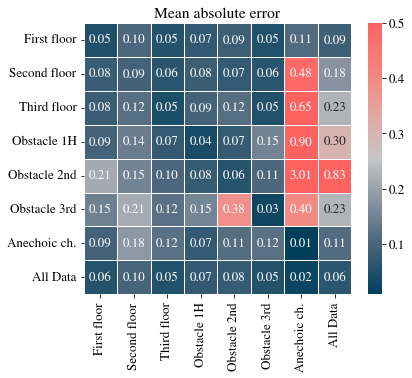

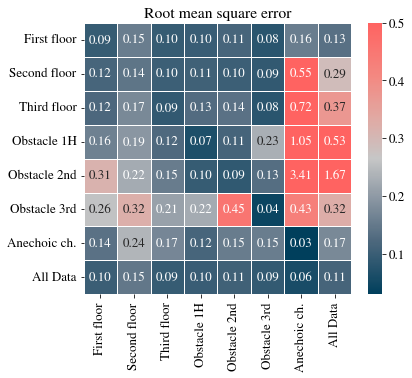

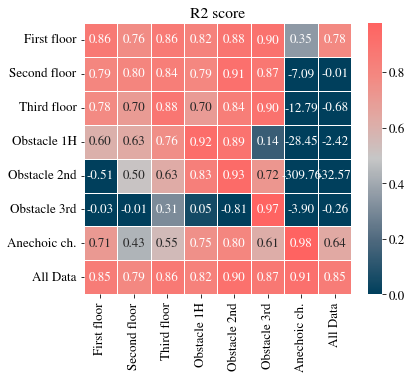

In [145]:
plot_heatmaps(score, rmse, mae, names=rmse.index)

<h4>Mix and match conclusions</h4>
The two outliers now seem to be the 3rd floor obstacle and the anechoic chamber data. I think that remving them might significantly improve the precision, but I will wait for the final results from Thierry before making a decision.

<h4>To do:</h4>

Look into the coefficients of the models for the different scenarios. 

Do a mix and match with training data and testing data. 

Change the size of the datasets so that they are all compatible with the smallest one.

Models without the 3rd floor obstacle and the anechoic chamber data.